# Recommending Movies

This notebook will explore the possibility of learning a set of movie watchers' (the "users") preferences for a set of movies. We use a database that has a rating for each movie the user has seen. There are a few datasets available: 

https://grouplens.org/datasets/movielens/

We will use the MovieLens 1M Dataset. It contains 1 million ratings from about 6000 users on about 4000 movies. Released 2/2003.

https://grouplens.org/datasets/movielens/1m/

Can we build a system that can learn to make recommendations for you?

This notebook follows after the Keras example here: https://github.com/ririw/ririw.github.io/blob/master/assets/Recommending%20movies.ipynb


In [1]:
import conx

Using Theano backend.
conx, version 3.5.9


First, we download the dataset:

In [2]:
conx.download("http://files.grouplens.org/datasets/movielens/ml-1m.zip")

Using cached http://files.grouplens.org/datasets/movielens/ml-1m.zip as './ml-1m.zip'.
Unzipping files...
Done!
Items available from downloaded zip file:
     ./ml-1m/
     ./ml-1m/movies.dat
     ./ml-1m/ratings.dat
     ./ml-1m/README
     ./ml-1m/users.dat
Available: 5 of 5.


We use pandas to parse and read in the data:

In [3]:
import pandas

In [4]:
# Read in the dataset, and do a little preprocessing,
# mostly to set the column datatypes.
users = pandas.read_csv('./ml-1m/users.dat', sep='::', 
                        engine='python', 
                        names=['userid', 'gender', 'age', 'occupation', 'zip']).set_index('userid')
ratings = pandas.read_csv('./ml-1m/ratings.dat', engine='python', 
                          sep='::', names=['userid', 'movieid', 'rating', 'timestamp'])
movies = pandas.read_csv('./ml-1m/movies.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre']).set_index('movieid')
movies['genre'] = movies.genre.str.split('|')

users.age = users.age.astype('category')
users.gender = users.gender.astype('category')
users.occupation = users.occupation.astype('category')
ratings.movieid = ratings.movieid.astype('category')
ratings.userid = ratings.userid.astype('category')

We get the number of movies and users:

In [5]:
n_movies = movies.shape[0]
n_users = users.shape[0]

In [6]:
n_movies, n_users

(3883, 6040)

## Designing the Dataset

In order to making a recommendation system, we wish to training a neural network to take in a user id and a movie id, and learning to output the user's rating for that movie.

Therefore, we need a list of movie ids, a list of user ids, and a list of the 1-5 ratings (called targets here):

In [7]:
# Also, make vectors of all the movie ids and user ids. These are
# pandas categorical data, so they range from 1 to n_movies and 1 to n_users, respectively.
movie_ids = ratings.movieid.cat.codes.values
user_ids = ratings.userid.cat.codes.values
targets = ratings.rating.values

Now we make a dataset. Because this network will have two input banks (users and movies) we need to specify that to the dataset so that it knows how to interpret the data.

In [8]:
ds = conx.Dataset(name="Movie Recommendations", input_shapes=[(1,), (1,)])

Now, we collect the [[movie_id], [user_id]] as inputs and the rating as a target. Note that we turn the 1-5 rating into a 0-4 value, and then make it a onehot representation. 

In [9]:
pairs = []
for i in range(len(movie_ids)):
    ins = [movie_ids[i]], [user_ids[i]]
    targs = conx.onehot(targets[i] - 1, 5)
    pairs.append([ins, targs])

In [10]:
ds.load(pairs)
ds

**Dataset name**: Movie Recommendations

**Dataset Split**:
   * training  : 1000209
   * testing   : 0
   * total     : 1000209

**Input Summary**:
   * shape  : [(1,), (1,)]
   * range  : [(0.0, 3705.0), (0.0, 6039.0)]

**Target Summary**:
   * shape  : [(5,)]
   * range  : [(0.0, 1.0)]



## Designing the Network

Because there are so many users and movies, we need a good way of representing them. In this example, we use an EmbeddingLayer. This will learn to represent users and movies in ways such that similar movies will have similar representations, and users with similar tastes will also have similar representations.

In [11]:
net = conx.Network("Recommender")
net.add(conx.InputLayer("movie", 1))
net.add(conx.EmbeddingLayer("movie_embed", n_movies + 1, 32))
net.add(conx.FlattenLayer("movie_flatten", dropout=0.5))
net.add(conx.InputLayer("user", 1))
net.add(conx.EmbeddingLayer("user_embed", n_users + 1, 32))
net.add(conx.FlattenLayer("user_flatten", dropout=0.5))
net.add(conx.Layer("dense1", 128, activation="relu", dropout=0.5))
net.add(conx.BatchNormalizationLayer("batch norm1"))
net.add(conx.Layer("dense2", 128, activation="relu", dropout=0.5))
net.add(conx.BatchNormalizationLayer("batch norm2"))
net.add(conx.Layer("dense3", 128, activation="relu", dropout=0.5))
net.add(conx.Layer("output", 5, activation="softmax"))

net.connect("movie", "movie_embed")
net.connect("movie_embed", "movie_flatten")
net.connect("user", "user_embed")
net.connect("user_embed", "user_flatten")
net.connect("movie_flatten", "dense1")
net.connect("user_flatten", "dense1")
net.connect("dense1", "batch norm1")
net.connect("batch norm1", "dense2")
net.connect("dense2", "batch norm2")
net.connect("batch norm2", "dense3")
net.connect("dense3", "output")

net.compile(optimizer='adam', error='categorical_crossentropy')
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, options=('Test', 'Train'), rows=1, value='Train'), FloatSlider(value=1.0, continuous_update=False, description='Zoom', max=3.0, min=0.5), IntText(value=150, description='Horizontal space between banks:', style=DescriptionStyle(description_width='initial')), IntText(value=30, description='Vertical space between layers:', style=DescriptionStyle(description_width='initial')), HBox(children=(Checkbox(value=False, description='Show Targets', style=DescriptionStyle(description_width='initial')), Checkbox(value=False, description='Errors', style=DescriptionStyle(description_width='initial')))), Select(description='Features:', options=('',), rows=1, value=''), IntText(value=3, description='Feature columns:', style=DescriptionStyle(description_width='initial')), FloatText(value=2.0, description='Feature scale:', style=DescriptionStyle(description_width='initial'))), layout=Layout(width='100%')), VBox(children=(Select(description='Layer:', index=11, options=('movie', 'movie_embed', 'movie_flatten', 'user', 'user_embed', 'user_flatten', 'dense1', 'batch norm1', 'dense2', 'batch norm2', 'dense3', 'output'), rows=1, value='output'), Checkbox(value=True, description='Visible'), Select(description='Colormap:', options=('', 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Vega10', 'Vega10_r', 'Vega20', 'Vega20_r', 'Vega20b', 'Vega20b_r', 'Vega20c', 'Vega20c_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spectral', 'spectral_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'viridis', 'viridis_r', 'winter', 'winter_r'), rows=1, value=''), HTML(value='<img src="data:image/gif;base64,R0lGODdhLAEZAIcAAPEBAY8AAM8AAAEB8q8AAAAAbwAAsAAAkAAA0PTo8vr3+wAAV0dH/7e3//9WVv/W1hYW/zQ0/2dn/4aG/6Sk/9nZ//8XF/82Nv9oaP+Xl/+1tSQk/1lZ/3h4/5SU/8nJ//8mJv9ERP95ef+Hh/+mpv/ExH8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

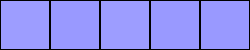

In [12]:
net.propagate_to_image("output", [[1], [n_users]], visualize=True)

In [13]:
net.set_dataset(ds)

Press the refresh button on the above dashboard to be able to examine the dataset.

Just practicing here:

In [14]:
net.dataset.chop(0.01) ## retain 1%

In [15]:
net.dataset

**Dataset name**: Movie Recommendations

**Dataset Split**:
   * training  : 10002
   * testing   : 0
   * total     : 10002

**Input Summary**:
   * shape  : [(1,), (1,)]
   * range  : [(0.0, 3705.0), (0.0, 6039.0)]

**Target Summary**:
   * shape  : [(5,)]
   * range  : [(0.0, 1.0)]



In [16]:
net.dataset.split(.10) # save 10% for testing

In [17]:
net.dataset

**Dataset name**: Movie Recommendations

**Dataset Split**:
   * training  : 9002
   * testing   : 1000
   * total     : 10002

**Input Summary**:
   * shape  : [(1,), (1,)]
   * range  : [(0.0, 3705.0), (0.0, 6039.0)]

**Target Summary**:
   * shape  : [(5,)]
   * range  : [(0.0, 1.0)]



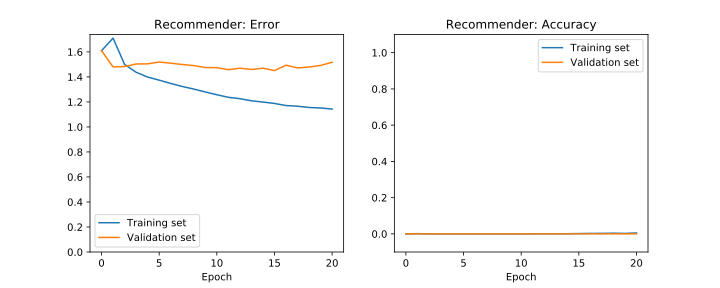

       |  Training |  Training |  Validate |  Validate 
Epochs |     Error |  Accuracy |     Error |  Accuracy 
------ | --------- | --------- | --------- | --------- 
#   20 |   1.14289 |   0.00500 |   1.51707 |   0.00000 


In [18]:
net.train(epochs=20, plot=True)

In [19]:
net.propagate_to("movie_flatten", net.dataset.inputs[0][0])

[0.02781016193330288,
 -0.010666389018297195,
 0.16660156846046448,
 0.008798418566584587,
 0.10968165844678879,
 0.09473316371440887,
 0.0580153651535511,
 0.07370173931121826,
 -0.12234977632761002,
 0.08490949124097824,
 -0.059495143592357635,
 0.11011652648448944,
 0.00045448710443452,
 0.036861296743154526,
 0.013147274032235146,
 -0.01456934679299593,
 0.07349030673503876,
 0.05409950390458107,
 0.1624561846256256,
 0.14145468175411224,
 -0.09628517925739288,
 -0.14296379685401917,
 -0.13446031510829926,
 -0.14138153195381165,
 -0.09240911900997162,
 0.0012846614699810743,
 0.09367069602012634,
 -0.035344887524843216,
 0.1156841367483139,
 0.050766438245773315,
 -0.1245001032948494,
 0.06929970532655716]

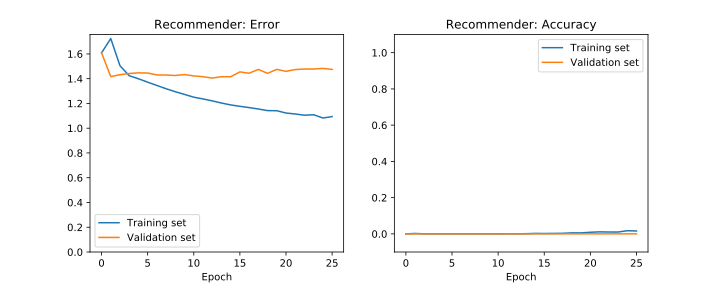

       |  Training |  Training |  Validate |  Validate 
Epochs |     Error |  Accuracy |     Error |  Accuracy 
------ | --------- | --------- | --------- | --------- 
#   25 |   1.09363 |   0.01600 |   1.47466 |   0.00000 


In [20]:
net.train(epochs=5, plot=True)

In [28]:
net.propagate_to("movie_flatten", net.dataset.inputs[0][0])

[-0.1257910579442978,
 0.06898871064186096,
 -0.000446645135525614,
 -0.07191003859043121,
 0.06409681588411331,
 0.046650175005197525,
 -0.02881365641951561,
 0.05911046639084816,
 -0.012821403332054615,
 0.014146249741315842,
 0.009905380196869373,
 0.10410133004188538,
 -0.023472772911190987,
 -0.10148665308952332,
 0.11437202990055084,
 0.029216617345809937,
 -0.04398423433303833,
 -0.07068465650081635,
 -0.11347535997629166,
 -0.04955267161130905,
 0.0496680773794651,
 -0.04173361882567406,
 0.0247291699051857,
 0.03433440625667572,
 -0.08818493783473969,
 -0.07845252752304077,
 0.017067544162273407,
 0.04157177358865738,
 0.14264075458049774,
 0.07800599932670593,
 0.028381582349538803,
 -0.03453972935676575]